# Jupyter Notebook of test_runner


In [1]:
import numpy as np
from model_loader import load_pretrained_model, load_dataloader
from augmentations import DataAugmentationTesting
from embeddings_similarity_module import EmbeddingSimilarityModule
#from cam_module import ClassActivationMapping
from collections import defaultdict
import logging
import random
import json
from tqdm import tqdm
import pickle
import os
import torch
import torch.nn.functional as F


# Create a logger object
logger = logging.getLogger('my_logger')
logger.setLevel(logging.DEBUG)  # Set the minimum level of messages to log

# Create a file handler that logs debug and higher level messages
file_handler = logging.FileHandler('example.log', mode='w')
file_handler.setLevel(logging.DEBUG)
file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(file_formatter)

# Create a console handler that logs debug and higher level messages
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(console_formatter)

# Add both handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

def load_config(config_path):
    with open(config_path, 'r') as config_file:
        return json.load(config_file)

def save_test_results(test_results, config):
    # Fetch the filename from the config dictionary
    filename = "test_results/"+config["test_name"] + '.pkl'  # Adding .pkl extension to the file name

    # Open the file in binary write mode and save the test_results using pickle
    with open(filename, 'wb') as file:
        pickle.dump(test_results, file)

    print(f"Test results saved to {filename}")

def select_test_idxs(dataloader, num_instances_per_class, all_class_labels):
    # Initialize storage for selected indices for each class
    class_indices = defaultdict(list)
    
    # Initialize counters for each class
    collected = {label: 0 for label in all_class_labels}  # Ensures we track per label in all_class_labels
    
    # Track selected indices to avoid duplicates
    selected_indices = set()

    # Calculate the total number of instances needed
    total_needed = num_instances_per_class * len(all_class_labels)

    # Iterate until the required number of indices per class is collected
    while sum(collected.values()) < total_needed:
        idx = random.randint(0, len(dataloader.dataset) - 1)
        if idx in selected_indices:
            continue
        
        # Fetch the label, assuming it is accessible and in correct format directly
        _, label = dataloader.dataset[idx]
        #print(label)
        


        # #check if label grabbed properly 
        # desired_type =all_class_labels[0]
        # if type(label) != desired_type:
        #     raise ValueError("Issue automatically reading label type, may need to edit select_test_idxs function.")
        
        # Check if more instances are needed for this class
        if collected[label] < num_instances_per_class:
            class_indices[label].append(idx)
            selected_indices.add(idx)
            collected[label] += 1

        # Verify if all quotas are met to potentially break the loop
        if all(count == num_instances_per_class for count in collected.values()):
            break

    # Flatten the dictionary into a list of indices
    test_idxs = [idx for indices in class_indices.values() for idx in indices]

    return test_idxs


def print_summary(test_results):
    """
    Print summary statistics for test results including accuracy,
    precision, recall, and counts of TP, TN, FP, FN for multi-class classification.
    """
    # Initialize counters and accumulators
    total_tests = len(test_results)
    num_classes = len(test_results[0]["output_aug"][0])

    aug_correct_predictions = 0
    og_correct_predictions = 0
    aug_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    og_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for result in test_results:
        # Convert model output 
        og_output_prob = F.softmax(torch.tensor(result["output_og"]), dim=-1).numpy()
        og_prediction = np.argmax(og_output_prob)
        true_label = result["og_label"]
        
        # Increment correct predictions
        if og_prediction == true_label:
            og_correct_predictions += 1
        
        # Update confusion matrix
        og_confusion_matrix[true_label, og_prediction] += 1


        # Convert model output 
        aug_output_prob = F.softmax(torch.tensor(result["output_aug"]), dim=-1).numpy()
        aug_prediction = np.argmax(aug_output_prob)
        true_label = result["og_label"]
        
        # Increment correct predictions
        if aug_prediction == true_label:
            aug_correct_predictions += 1
        
        # Update confusion matrix
        aug_confusion_matrix[true_label, aug_prediction] += 1

    # Calculate accuracy
    aug_accuracy = (aug_correct_predictions / total_tests) * 100 if total_tests > 0 else 0
    og_accuracy = (og_correct_predictions / total_tests) * 100 if total_tests > 0 else 0

    # Calculate precision and recall for each class
    precision = np.diag(aug_confusion_matrix) / np.sum(aug_confusion_matrix, axis=0)
    recall = np.diag(aug_confusion_matrix) / np.sum(aug_confusion_matrix, axis=1)

    # Print summary
    print(f"Total number of test results: {total_tests}")
    print(f"Model Accuracy on original: {og_accuracy:.2f}%")
    print(f"Model Accuracy on augmentation: {aug_accuracy:.2f}%")
    for i in range(len(precision)):
        TP = aug_confusion_matrix[i, i]
        FP = np.sum(aug_confusion_matrix[:, i]) - TP
        FN = np.sum(aug_confusion_matrix[i, :]) - TP
        TN = np.sum(aug_confusion_matrix) - (TP + FP + FN)
        print(f"Augmented Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

    # Optionally, print the confusion matrix
    print("Aug Confusion Matrix:")
    print(aug_confusion_matrix)
    print("Original Confusion Matrix:")
    print(og_confusion_matrix)


In [2]:
#***************************************************      Load Model and dataloader        *************************************************************
config_path = "config_oracle.json"
#config_path = "config_tprime_cnn.json"
config = load_config(config_path)
model = load_pretrained_model(config)
logging.info("Model Loaded")

dataloader = load_dataloader(config)
logging.info("Dataloader Loaded")

AlexNet1D(
  (feature_extractor): ModuleList(
    (0): Conv1d(2, 128, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (11): ReLU()
    (12): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=same)
    (16): ReLU()
    (17): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
    (18): ReLU()

In [3]:
#oracle specific debugging

# def test_in_distribution(model, dataset):
#     #dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#     slice_accs = []
#     example_majority_accs = []
#     example_sum_accs = []
#     for i, (trans, label) in enumerate(dataloader):
#         # print(i, len(dataset))
#         trans, label = trans[0], label[0]
#         with torch.no_grad():
#             pred = model(trans)
#             pred_class = torch.argmax(pred, dim=-1)
#         accuracy = torch.mean((pred_class == label).float()).cpu().numpy()
#         majority_accuracy = (torch.mode(pred_class)[0] == label).float().cpu().numpy()
#         sum_accuracy = (torch.argmax(torch.sum(pred, dim=0)) == label).float().cpu().numpy()
#         slice_accs.append(accuracy)
#         example_majority_accs.append(majority_accuracy)
#         example_sum_accs.append(sum_accuracy)

#         if i > 20:
#             break
#     return np.mean(np.asarray(slice_accs)), np.mean(np.asarray(example_majority_accs)), np.mean(
#         np.asarray(example_sum_accs))


# if __name__ == "__main__":
#     print(test_in_distribution(model, dataloader))


In [4]:
#oracle specific debugging

for i, (trans, label) in enumerate(dataloader):
        # print(i, len(dataset))
        print("Original trans shape:", trans.shape)  # For debugging purposes
        print("Original label shape:", label.shape)
        print(trans)
        print(label)

        # # Index into the tensor to select the first sample
        # # trans has shape [batch_size, 1745, 2, 256]
        # # We want to select one sample to get shape [1, 2, 256]
        # trans_sample = trans[0, 0]  # Select the first sample from the first batch
        # print("Shape after indexing trans[0, 0]:", trans_sample.shape)  # Should be [2, 256]

        # # Add a batch dimension back
        # trans_sample = trans_sample.unsqueeze(0)  # Shape becomes [1, 2, 256]
        # print("Shape after unsqueeze:", trans_sample.shape)

        # # Similarly for label
        # # Assuming label has shape [1745], select the first label
        # label_sample = label[0]
        # label_sample = label_sample.unsqueeze(0)  # Shape becomes [1]
        # print("Label sample shape:", label_sample.shape)
        # print(trans.shape)
        with torch.no_grad():
            pred = model(trans)
            softmax_preds = np.argmax(F.softmax(pred, dim=1).detach().cpu().numpy())
        
        print(pred,"max:", softmax_preds)
        print("label", label)
        
        if i >2:
              break

Original trans shape: torch.Size([1, 2, 256])
Original label shape: torch.Size([1])
tensor([[[ 0.5799,  0.0305, -0.2136, -0.0916,  0.1526,  0.6714,  0.3967,
          -0.3052, -0.0610,  0.1526,  0.0305, -0.2136,  0.0916, -0.6409,
           0.3357,  0.3052,  0.3052, -0.0305, -0.5493, -0.3967, -0.4273,
           0.3662, -0.0610,  0.0305, -0.1831,  0.1526,  0.4578, -0.6104,
           0.4578, -0.1221,  0.3052,  0.3052, -0.6714,  0.6409,  0.0000,
          -0.1526, -0.1221, -0.9156,  0.4273, -0.2747, -0.7935,  0.6409,
           0.4883, -0.2747,  0.1221,  0.1831,  0.1831,  0.2136,  0.9461,
          -0.5188, -0.4883,  0.2747, -0.5188,  0.2136,  0.7935,  0.0610,
           0.0305,  0.5799,  0.3357, -0.0916,  0.2747,  0.3662,  0.0305,
          -0.0916,  0.2747, -0.1831, -0.4273, -0.2136, -0.2747,  0.0000,
          -0.4273,  0.0916,  0.3357,  0.0916,  0.3357,  0.3662, -0.0610,
          -0.0916,  0.5493, -0.9766,  0.0305,  0.3052, -0.2136, -0.1831,
          -0.6714, -0.2441,  0.0916, -0.

In [5]:
#***************************************************      Prepare AURA Test set  *************************************************************
all_class_labels = config["dataset"]["all_class_labels"] # needs to match your dataloader labels
num_instances_per_class = config["num_instances_per_class"]
print(len(dataloader.dataset))
if num_instances_per_class > len(dataloader.dataset)/len(all_class_labels):
    raise ValueError("num_instances_per_class is greater than test dataset size/ num classes. Please reduce test size in config.")
test_index_list = select_test_idxs(dataloader, num_instances_per_class,all_class_labels)
logging.info("Test list created and Loaded")
#print(test_index_list)



103092


In [6]:
#optional reload the config, can be helpful when doing manual experiments to avoid reloading dataset
config = load_config(config_path)
print(config["test_name"])

awgn_oracle_JSAC_mimick_power_epoch9_IQ_Imbal_103gain_3deg


In [7]:
# Initialize the Data Augmentation Module
augmentor_sandbox = DataAugmentationTesting(model, dataloader, config)

# # Initialize processing modules
embedding_similarity_module = EmbeddingSimilarityModule(model, dataloader, config)

In [8]:

# Prepare to collect results
test_results = []

# Run tests on the specific range of indexes
for index in tqdm(test_index_list, desc="Processing indexes"):

    # Check if noise test is enabled
    if config["augmentation_test_params"]["noise"]["enable_test"]:
        #Run AWGN Aug Test *************************************
        # Augment the sample
        augmentor_sandbox.replace_with_noise(index)

        # Get the augmented sample
        awgn_aug_sample, aug_label = augmentor_sandbox.awgn_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        
        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(awgn_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)

        # Compute embedding similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(awgn_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        es_result = 0 #TODO compute distance metric for similarity
        # embedding_similarity_module.plot_tsne(es_features, es_label)
        # # # Compute class activation mapping
        # cam_result = cam.compute(augmented_sample, model_output)
        cam_result = None
        #print(len(es_features_og), len(es_features_aug))
        # Store results
        test_results.append({
            "test": "awgn",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og":es_features_og,
            "embedding_features_aug":es_features_aug,
            "cam_result": cam_result
        })
        #**************** end awgn aug datatest *****************************

    # Check if test is enabled
    if config["augmentation_test_params"]["CFO"]["enable_test"]:
        #Run CFO Aug Test *************************************
        # Augment the sample (creates new augmented cfo dataset as well)
        augmentor_sandbox.add_frequency_offset(index)

        # Get the augmented sample
        cfo_aug_sample, aug_label = augmentor_sandbox.cfo_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(cfo_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)
        #print(output_og)

        # Compute embedding similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(cfo_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        es_result = 0 #TODO compute distance metric for similarity
        # embedding_similarity_module.plot_tsne(es_features, es_label)

        # # Compute class activation mapping
        # cam_result = cam.compute(augmented_sample, model_output)
        cam_result = None
        # Store results
        test_results.append({
            "test": "cfo",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og":es_features_og,
            "embedding_features_aug":es_features_aug,
            "cam_result": cam_result
        })
    #**************** end CFO aug datatest *****************************

    # Check if SNR reduction test is enabled
    if config["augmentation_test_params"]["SNR"]["enable_test"]:
        # Run SNR Reduction Test *************************************
        # Augment the sample (creates new augmented snr dataset as well)
        augmentor_sandbox.reduce_SNR(index)

        # Get the augmented sample
        snr_aug_sample, aug_label = augmentor_sandbox.snr_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(snr_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)

        # Compute embedding similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(snr_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        # embedding_similarity_module.plot_tsne(
        #     es_features_og, es_features_aug, og_label, aug_label, test_type="SNR Test"
        # )
        es_result = 0 #TODO compute distance metric for similarity

        # Compute class activation mapping
        cam_result = None  # Placeholder

        # Store results
        test_results.append({
            "test": "snr",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og": es_features_og,
            "embedding_features_aug": es_features_aug,
            "cam_result": cam_result
        })
        #**************** end SNR reduction test *****************************

    if config["augmentation_test_params"]["FSPL"]["enable_test"]:
        # Run FSPL Test *************************************
        # Augment the sample (creates new augmented fspl dataset as well)
        augmentor_sandbox.apply_FSPL(index)

        # Get the augmented sample
        fspl_aug_sample, aug_label = augmentor_sandbox.fspl_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(fspl_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)

        # Compute embedding similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(fspl_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        es_result = 0 #TODO compute distance metric for similarity

        # Compute class activation mapping
        cam_result = None  # Placeholder for CAM computation

        # Store results
        test_results.append({
            "test": "fspl",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og": es_features_og,
            "embedding_features_aug": es_features_aug,
            "cam_result": cam_result
        })
        #**************** end FSPL test *****************************
    
    if config["augmentation_test_params"]["phase_rotation"]["enable_test"]:
        # Run Phase Rotation Test *************************************
        # Augment the sample (creates new augmented phase rotation dataset as well)
        augmentor_sandbox.apply_phase_rotation(index)

        # Get the augmented sample
        phase_rot_aug_sample, aug_label = augmentor_sandbox.phase_rot_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(phase_rot_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)

        # Compute embedding similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(phase_rot_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        es_result = 0 #TODO compute distance metric for similarity

        # Compute class activation mapping
        cam_result = None  # Placeholder for CAM computation

        # Store results
        test_results.append({
            "test": "phase_rotation",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og": es_features_og,
            "embedding_features_aug": es_features_aug,
            "cam_result": cam_result
        })
        #**************** end Phase Rotation test *****************************
    
    # Check if IQ imbalance test is enabled
    if config["augmentation_test_params"]["IQ_imbalance"]["enable_test"]:
        # Run IQ Imbalance Test *************************************
        # Augment the sample (creates new augmented IQ imbalance dataset as well)
        augmentor_sandbox.apply_IQ_imbalance(index)

        # Get the augmented sample
        iq_aug_sample, aug_label = augmentor_sandbox.iq_aug_data.__getitem__(index)
        og_sample, og_label = augmentor_sandbox.get_original_sample(index)

        # Run model inference on augmented sample and original
        output_aug = augmentor_sandbox.run_model_on_sample(iq_aug_sample)
        output_og = augmentor_sandbox.run_model_on_sample(og_sample)

        # Compute embedding similarity
        # Assuming `embedding_similarity_module` is set up to extract features and compute similarity
        es_features_aug, es_label_aug = embedding_similarity_module.extract_features(iq_aug_sample, aug_label)
        es_features_og, es_label_og = embedding_similarity_module.extract_features(og_sample, og_label)
        es_result = 0 # Placeholder for actual similarity computation, implement as needed

        # Compute class activation mapping
        cam_result = None  # Placeholder for CAM computation, assuming `cam` is set up to compute this
        # cam_result = cam.compute(iq_aug_sample, output_aug) - if CAM computation is defined

        # Store results
        test_results.append({
            "test": "IQ_imbalance",
            "index": index,
            "og_label": og_label,
            "aug_label": aug_label,
            "output_og": output_og,
            "output_aug": output_aug,
            "embedding_similarity": es_result,
            "embedding_features_og": es_features_og,
            "embedding_features_aug": es_features_aug,
            "cam_result": cam_result
        })
        #**************** end IQ Imbalance test *****************************

    
    

# # Optionally, save and summarize results
save_test_results(test_results, config)
print_summary(test_results)


Processing indexes: 100%|██████████| 600/600 [00:06<00:00, 93.72it/s] 


Test results saved to test_results/awgn_oracle_JSAC_mimick_power_epoch9_IQ_Imbal_103gain_3deg.pkl
Total number of test results: 600
Model Accuracy on original: 98.83%
Model Accuracy on augmentation: 92.50%
Augmented Class 0 - Precision: 0.9889, Recall: 0.8900, TP: 89, TN: 499, FP: 1, FN: 11
Augmented Class 1 - Precision: 0.9423, Recall: 0.9800, TP: 98, TN: 494, FP: 6, FN: 2
Augmented Class 2 - Precision: 0.9878, Recall: 0.8100, TP: 81, TN: 499, FP: 1, FN: 19
Augmented Class 3 - Precision: 0.8889, Recall: 0.9600, TP: 96, TN: 488, FP: 12, FN: 4
Augmented Class 4 - Precision: 0.9510, Recall: 0.9700, TP: 97, TN: 495, FP: 5, FN: 3
Augmented Class 5 - Precision: 0.8246, Recall: 0.9400, TP: 94, TN: 480, FP: 20, FN: 6
Aug Confusion Matrix:
[[89  0  1  1  3  6]
 [ 0 98  0  0  0  2]
 [ 1  1 81  9  1  7]
 [ 0  2  0 96  0  2]
 [ 0  0  0  0 97  3]
 [ 0  3  0  2  1 94]]
Original Confusion Matrix:
[[ 99   0   0   0   1   0]
 [  0 100   0   0   0   0]
 [  0   0  99   1   0   0]
 [  0   1   0  99   0  

[0 1 2 3 4 5]
600
here 600
[0 1 2 3 4 5]


/home/sagetrudeau/Projects/XAI/xai_venv/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


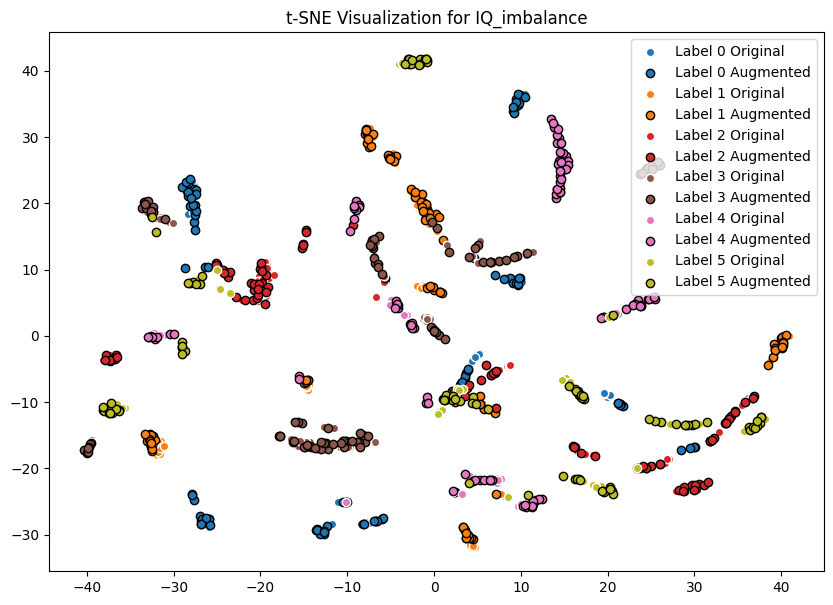

In [ ]:
def aggregate_and_plot_tsne(test_results, selected_tests=None, indexes_to_plot=None):
    """
    Aggregates test results and plots t-SNE for selected tests.

    :param test_results: List of dictionaries containing test outputs.
    :param selected_tests: List of test types to plot. If None, plots all tests.
    :param indexes_to_plot: List of specific indexes to plot for augmented data; plots all if None.
    """
    test_data = {}

    # Aggregate data
    for i, result in enumerate(test_results):
        test_type = result['test']
        #print(len(result['embedding_features_og'][0]),len(result['embedding_features_aug'][0]))
        # Continue only if test_type is in the selected_tests or if selected_tests is None
        if selected_tests is not None and test_type not in selected_tests:
            continue

        if test_type not in test_data:
            test_data[test_type] = {'features_og': [], 'features_aug': [], 'labels_og': [], 'labels_aug': []}

        # Always include original features and labels, ensure labels are numpy arrays
        test_data[test_type]['features_og'].append(result['embedding_features_og'])
        test_data[test_type]['labels_og'].append(np.array([result['og_label']]))

        # Include augmented features and labels based on specific indexes, if provided
        if indexes_to_plot is None or i in indexes_to_plot:
            test_data[test_type]['features_aug'].append(result['embedding_features_aug'])
            test_data[test_type]['labels_aug'].append(np.array([result['aug_label']]))

    # Plot data

    for test, data in test_data.items():
        if data['features_og']:  # Ensure there are original features to plot
            features_og = np.concatenate(data['features_og'], axis=0)
            labels_og = np.concatenate(data['labels_og'])
            print(np.unique(labels_og))
            num_original = len(data['features_og'])
            print(num_original)
        else:
            raise ValueError("no features to plot selected")

        if data['features_aug']:  # Check if there are any augmented features to plot
            features_aug = np.concatenate(data['features_aug'], axis=0)
            labels_aug = np.concatenate(data['labels_aug'])
            print("here", len(features_aug))

        else:
            features_aug = np.array([])
            labels_aug = np.array([])

        
        all_features = np.vstack((features_og, features_aug)) if features_aug.size else features_og
        all_labels = np.concatenate((labels_og, labels_aug)) if labels_aug.size else labels_og
        print(np.unique(all_labels))
        embedding_similarity_module.plot_tsne(all_features, all_labels, num_original, test)


# aggregate_and_plot_tsne(test_results, selected_tests=['snr'], indexes_to_plot=[1])
#aggregate_and_plot_tsne(test_results, selected_tests=['awgn'],indexes_to_plot=[1])
aggregate_and_plot_tsne(test_results, selected_tests=['awgn'])